# Problem 1

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import norm
import matplotlib.pyplot as plt
from lib_hcy_week5 import myfunctions as mf

In [2]:
def time_to_maturity(cur_date, exp_date):
    ttm = (exp_date - cur_date).days / 365
    return ttm
cur_date = datetime(2023, 3, 3)
exp_date = datetime(2023, 3, 17)
ttm = time_to_maturity(cur_date, exp_date)
print("Time to Maturity is ",round(ttm, 4))

Time to Maturity is  0.0384


In [3]:
def BS_option(option_type, S, X, T, sigma, r, b):
    d1 = (np.log(S/X)+(b + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "Call":
        call_value = S * np.exp((b - r) * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
        return call_value
    else:
        put_value = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp((b-r) * T) * norm.cdf(-d1)
        return put_value

In [4]:
S = 165
X_call = 150 # set the strike price of call option to be 150
X_put = 180 # set the strike price of put option to be 180
r = 0.0525
coupon = 0.0053
b = r - coupon

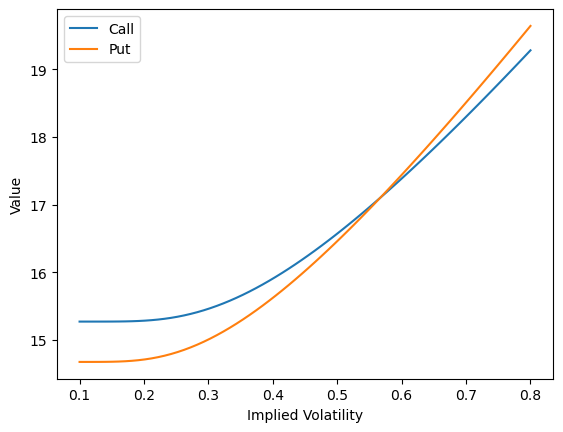

In [5]:
call_values = []
put_values = []
sigmas = np.linspace(0.1, 0.8, 70)
for sigma in sigmas:
    call_value = BS_option("Call", S, X_call, ttm, sigma, r, b)
    call_values.append(call_value)
    put_value = BS_option("Put", S, X_put, ttm, sigma, r, b)
    put_values.append(put_value)

plt.figure()
plt.plot(sigmas, call_values, label="Call")
plt.plot(sigmas, put_values, label="Put")
plt.xlabel("Implied Volatility")
plt.ylabel("Value")
plt.legend()
plt.show()

# Problem 2

In [6]:
from scipy.optimize import brentq
from scipy.optimize import fsolve

In [7]:
df = pd.read_csv('AAPL_Options.csv')
c_date = pd.to_datetime('2023-10-30')
df['T'] = (pd.to_datetime(df['Expiration']) - c_date).dt.days/365

In [9]:
def gbsm(option_type, S, X, r, b, sigma, T):
    d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S*np.exp((b-r)*T)*norm.cdf(d1) - X*np.exp(-r*T)*norm.cdf(d2)
    else:
        return X*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp((b-r)*T)*norm.cdf(-d1)

def implied_vol(option_type, S, X, T, r, b, market_price, x0=0.5):
    def equation(sigma):
        return gbsm(option_type, S, X, r, b, sigma, T) - market_price
    return fsolve(equation, x0=x0, xtol=0.0001)[0]

In [10]:
S = 170.15
r = 0.0525
q = 0.0057
b = r - q
T = time_to_maturity(datetime(2023, 10, 30), datetime(2023, 12, 15))

call_market = df[df["Type"]=="Call"]["Last Price"].tolist()
put_market = df[df["Type"]=="Put"]["Last Price"].tolist()
call_strike = df[df["Type"]=="Call"]["Strike"].tolist()
put_strike = df[df["Type"]=="Put"]["Strike"].tolist()
call_T = df[df["Type"]=="Call"]["T"].tolist()
put_T = df[df["Type"]=="Put"]["T"].tolist()
call_iv = []
put_iv = []
for i in range(len(call_market)):
    call_iv.append(implied_vol('call', S, call_strike[i], call_T[i], r, b, call_market[i]))
    put_iv.append(implied_vol('put', S, put_strike[i], put_T[i], r, b, put_market[i]))

/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


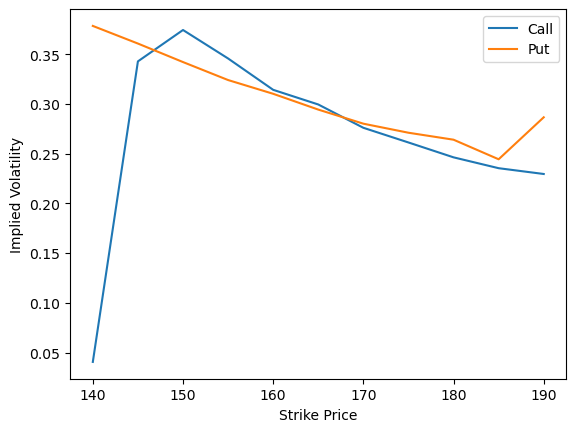

In [11]:
plt.plot(call_strike, call_iv, label='Call')
plt.plot(put_strike, put_iv, label='Put')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [12]:
def find_iv(option_type, S, X, T, r, b, price, guess):
    # option_type: the type of the option
    # S: current price of the underlying asset.
    # X: strike price of the option.
    # T: time to expiration of the option
    # r: risk-free interest rate
    # b: cost of carry. In the Black-Scholes model, this is usually the same as the risk-free rate
    # price: market price of the option, which is used to calculate the implied volatility.
    # guess: an initial guess for the implied volatility
    def f(iv): # compute the difference between the theoretical price of the option (calculated using the Black-Scholes model) and the actual market price (price)
        return BS_option(option_type, S, X, T, iv, r, b) - price
    return brentq(f, guess, 8, xtol=1e-6, rtol=1e-6) # brentq() used to find the root of the function f - the value of iv that makes f(iv) equal to zero.
    # 1 means iv shall not be higher than 100%
    # xtol: The tolerance for the solution's accuracy along the x-axis (IV in this case)
    # rtol: The tolerance for the solution's accuracy relative to the size of the root.

In [13]:
AAPL_options = pd.read_csv("AAPL_Options.csv", parse_dates=["Expiration"])
S = 170.15
T = time_to_maturity(datetime(2023, 10, 30), datetime(2023, 12, 15))
r = 0.0525
coupon = 0.0057
b = r - coupon
call_X = []
call_iv =[]
put_X = []
put_iv = []
for i in range(len(AAPL_options)):
    option_type = AAPL_options['Type'][i]
    X = AAPL_options['Strike'][i]
    if i == 0:
        price = AAPL_options['Last Price'][i] + 0.0015 # to prevent the problem of "f(a) and f(b) must have different signs" in brentq(), we have to add a small number to the first price, it works well with all other prices, though
    else:
        price = AAPL_options['Last Price'][i]
    implied_volatility = find_iv(option_type, S, X, T, r, b, price, 0.0001)
    if option_type == "Call":
        call_X.append(X)
        call_iv.append(implied_volatility)
    if option_type == "Put":
        put_X.append(X)
        put_iv.append(implied_volatility)

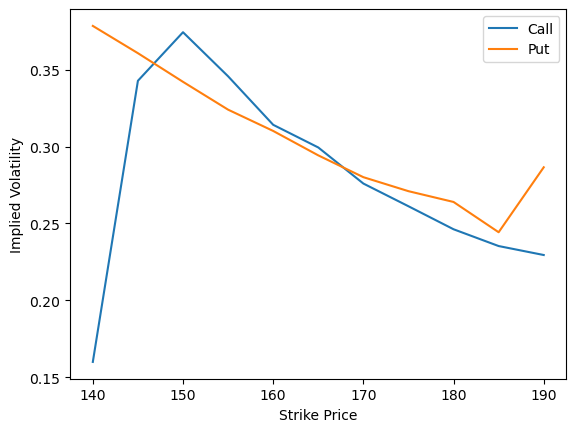

In [14]:
plt.figure()
plt.plot(call_X, call_iv, label="Call")
plt.plot(put_X, put_iv, label="Put")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [15]:
# test of a corner case
option_type = 'call'
S = 170.15  # Current stock price
X = 140     # Strike price
T = time_to_maturity(datetime(2023, 10, 30), datetime(2023, 12, 15))
r = 0.0525  # Risk-free interest rate
coupon = 0.0057  # Dividend yield
b = r - coupon  # Cost of carry
price = 30.95  # Market price of the option

def BS_option(option_type, S, X, T, sigma, r, b):
    d1 = (np.log(S/X)+(b + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "Call":
        call_value = S * np.exp((b - r) * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
        return call_value
    else:
        put_value = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp((b-r) * T) * norm.cdf(-d1)
        return put_value

# Define the function f(iv) for which you want to find the root
def f(iv):
    return BS_option(option_type, S, X, T, iv, r, b) - price

# Evaluate the function at the lower and upper bounds
lower_bound_value = f(0.00001)  # Replace 'guess' with your initial guess for IV
upper_bound_value = f(1)

# Check if there's a sign change
if lower_bound_value * upper_bound_value > 0:
    print("No sign change: f(guess) =", lower_bound_value, "f(1) =", upper_bound_value)
    # You may need to adjust your bounds or initial guess
else:
    print("Sign change detected: f(guess) =", lower_bound_value, "f(1) =", upper_bound_value)
    # The bounds are likely correct, and brentq should work

No sign change: f(guess) = -30.95 f(1) = -21.303226342554968


# Problem 3

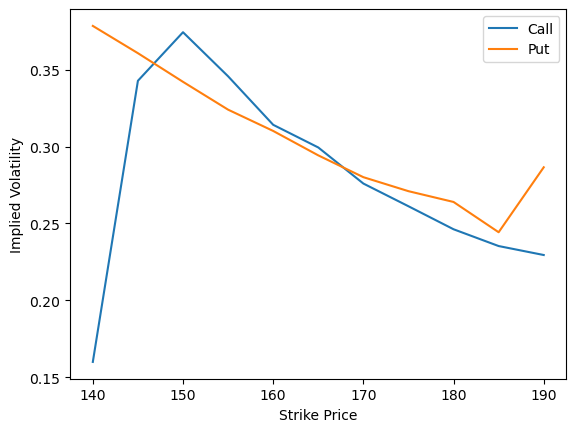